## Total public space
Load land use polygons and water bodies

In [1]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from pyproj import CRS

In [2]:
# Define paths
ITF_geospatial = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/data/geospatial/ITF/'
APUR_geospatial = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/data/geospatial/APUR/'
RESULTS = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/results/'
ox_geocode = 'Paris, France' 

### Load

In [3]:
# Load clipped version if ilot file
paris_ilot = gpd.read_file(APUR_geospatial+'ilot_physique_epsg4326_clipped.shp')

### Add water

In [4]:
# Load from OSM
water = ox.geometries_from_place(ox_geocode, tags={"natural": "water"}) # not clipped to Paris City boundaries

# Clip and reset index
paris = ox.geocode_to_gdf(ox_geocode)
clipped = gpd.clip(water, paris).reset_index(drop=True)

# Create some columns also present in APUR file
clipped['d_c_type_i'] = 'Water'
clipped['c_type_il'] = 'W'
clipped['changed'] = False
clipped['Shape_Leng'] = np.nan
clipped['Shape_Area'] = np.nan
clipped['index'] = clipped.index

# Drop all columns not in common between both
intersect = list(set(paris_ilot.columns) & set(clipped.columns))
for gdf in [paris_ilot, clipped]:
    to_drop = [col for col in gdf.columns if col not in intersect]
    gdf.drop(columns = to_drop, inplace=True)
    
# Merge
paris = gpd.GeoDataFrame(pd.concat([paris_ilot, clipped]))

# Rename type columns
rename = {
    'P': 'G', #reen
    'T': 'B', #ank
    'V': 'S', #quare
    'N': 'P', #lot
    'Q': 'D', #ock
    'W': 'W', #ater
}
rename_d = {
    'Ilot végétalisé ou planté': 'Pedestrian square or plot with greenspace',
    'Talus': 'River bank', 
    'Ilot de voirie': 'Pedestrian square or refuge island without greenspace', 
    'Ilot Normal': 'Impermeable plot (mostly buildings)',  
    'Quai': 'Dock',
    'Water': 'River, lake or canal', 
}
paris.c_type_il = paris.c_type_il.map(lambda x: rename[x])
paris.d_c_type_i = paris.d_c_type_i.map(lambda x: rename_d[x])

C:\Users\marno\AppData\Local\Temp\ipykernel_992\1476653431.py:2: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water = ox.geometries_from_place(ox_geocode, tags={"natural": "water"}) # not clipped to Paris City boundaries
C:\Users\marno\AppData\Roaming\Python\Python310\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [5]:
paris.d_c_type_i.unique()

array(['Pedestrian square or plot with greenspace', 'River bank',
       'Pedestrian square or refuge island without greenspace',
       'Impermeable plot (mostly buildings)', 'Dock',
       'River, lake or canal'], dtype=object)

### Visualize

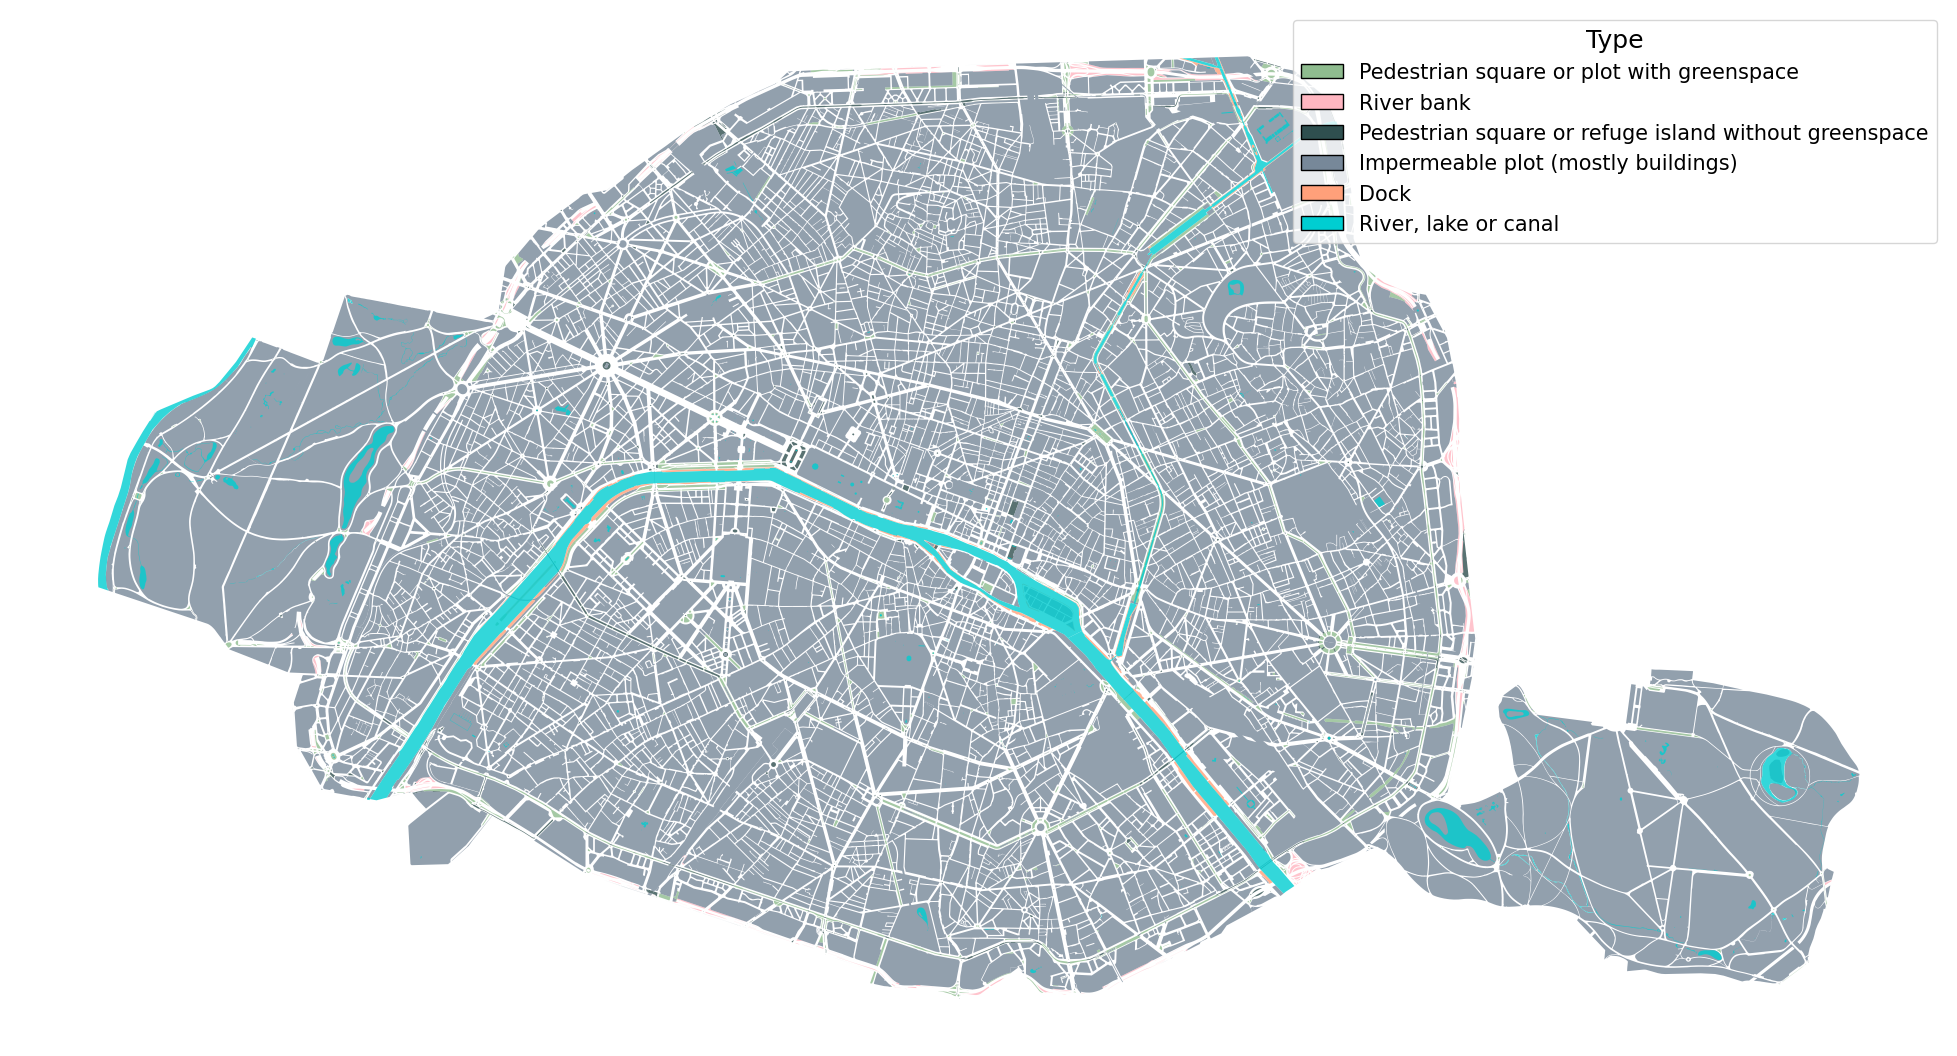

In [10]:
# Define the custom colors for each categorical value
custom_colors = {
    'Pedestrian square or plot with greenspace': '#8FBC8F', # darkseagreen
    'River bank': '#FFB6C1', # lightpink
    'Pedestrian square or refuge island without greenspace': '#2F4F4F', # darkslategrey
    'Impermeable plot (mostly buildings)': '#778899', #lightslategrey 
    'Dock': '#FFA07A', # lightsalmon
    'River, lake or canal': 'darkturquoise', # darkturquoise
}
# https://python-charts.com/colors/

# Plot polygons and multipolygons with custom colors
fig, ax = plt.subplots(1,1,figsize=(25,25))

for geom_type, color in custom_colors.items():
    subset = paris[paris['d_c_type_i'] == geom_type]
#     subset.boundary.plot(ax=ax, edgecolor=color)
    subset.plot(ax=ax, color=color, alpha=0.8)
plt.gca().axis('off')

# Create custom legend
legend_elements = [Patch(facecolor=color, edgecolor='k', label=label) for label, color in custom_colors.items()]
ax.legend(handles=legend_elements, title='Type', title_fontsize=18, fontsize=15, fancybox=True)

In [13]:
fig.savefig(RESULTS+'surface_map')

### Compute total public space
Need to select non-road surfaces and obtain negative geometry, then compute metric surface area from lat/lon defined geometry <br>
<b>Assumption:</b> river banks and docks are public space, rivers are not

In [14]:
# Non-road surfaces: 'Impermeable plot (mostly buildings)', 'River, lake or canal'
non_road_types = ['P', 'W']
non_public = paris.loc[paris.c_type_il.isin(non_road_types)]

# Unary type needed to use the difference function
non_public_union = non_public.unary_union

# Compute difference between shape of paris and non-public space to obtain public space
container = ox.geocode_to_gdf(ox_geocode)
public = container.difference(non_public_union)

In [15]:
# Project to an equal-area CRS (e.g., EPSG:6933 - WGS 84 / NSIDC EASE-Grid 2.0 Global)
equal_area_crs = CRS("EPSG:6933")
gdf_equal_area = public.to_crs(equal_area_crs)
ha = int(sum(gdf_equal_area.area)/10000)

# Print the area
print(f'{ha} ha')

2677 ha


Which roughly corresponds to the 2463 ha in the APUR parking study

### Combine plots

Text(0.9, 0.9, 'Surface area:\n 2677 ha')

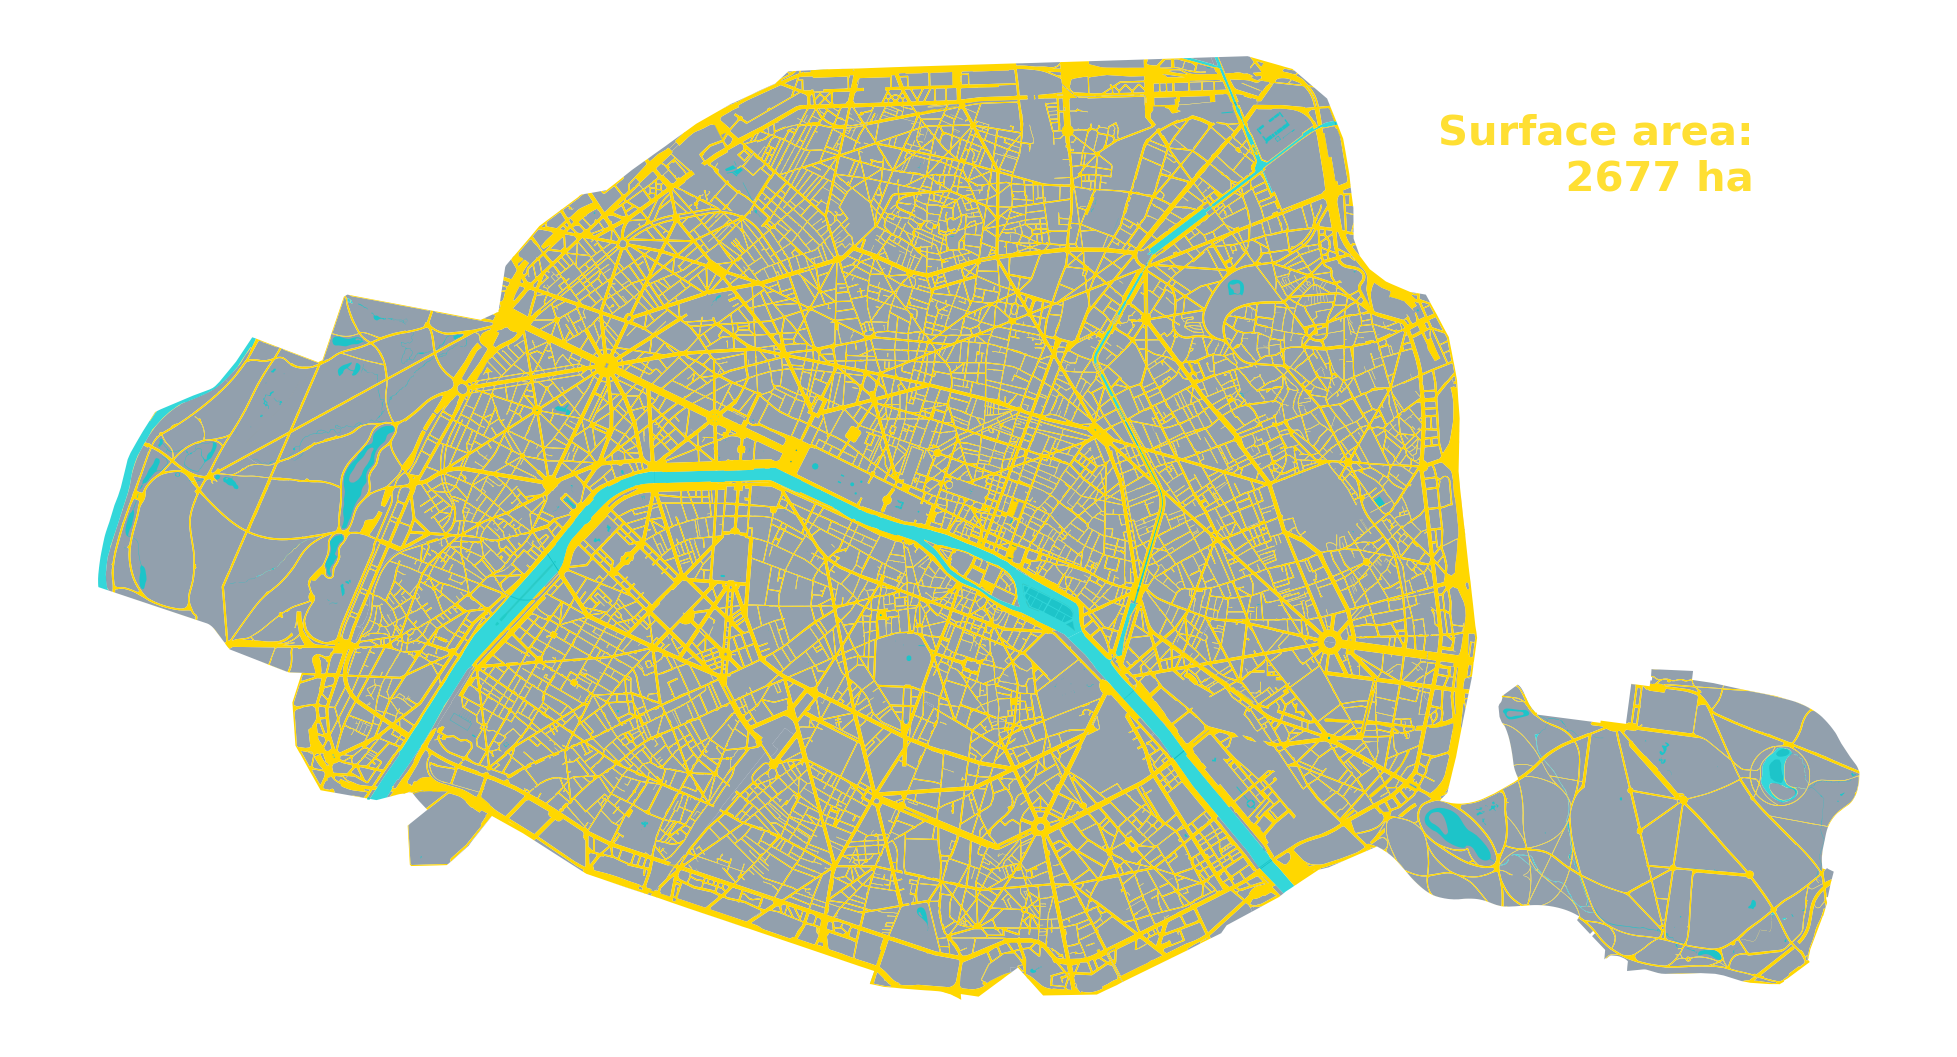

In [16]:
fig, ax = plt.subplots(1,1,figsize=(25,25))
c_marked = '#FFD700'

for geom_type, color in custom_colors.items():
    subset = paris[paris['d_c_type_i'] == geom_type]
#     subset.boundary.plot(ax=ax, edgecolor=color)
    subset.plot(ax=ax, color=color, alpha=0.8)
plt.gca().axis('off')

public.plot(ax=ax, color=c_marked, alpha=1)

text = f'Surface area:\n {ha} ha'
x = 0.9  # Position on the x-axis (0 to 1, where 1 is the far right)
y = 0.9  # Position on the y-axis (0 to 1, where 1 is the top)

# Add the text to the plot
# ha='right' aligns the text to the right
# va='top' aligns the text to the top
ax.text(x, y, text, transform=ax.transAxes, fontsize=30, color = c_marked, weight='bold', ha='right', va='top', alpha = 0.8)

In [17]:
fig.savefig(RESULTS+'public_space')